In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

In [2]:
df = pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/car data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


# Предобработка данных

In [4]:
#df['Car_Name'].nunique()  # 98 из 301 -> не будем учитывать
df.drop("Car_Name", axis=1, inplace=True)
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)

Поиск значений сильно отличающихся от остальных (**outliers**)

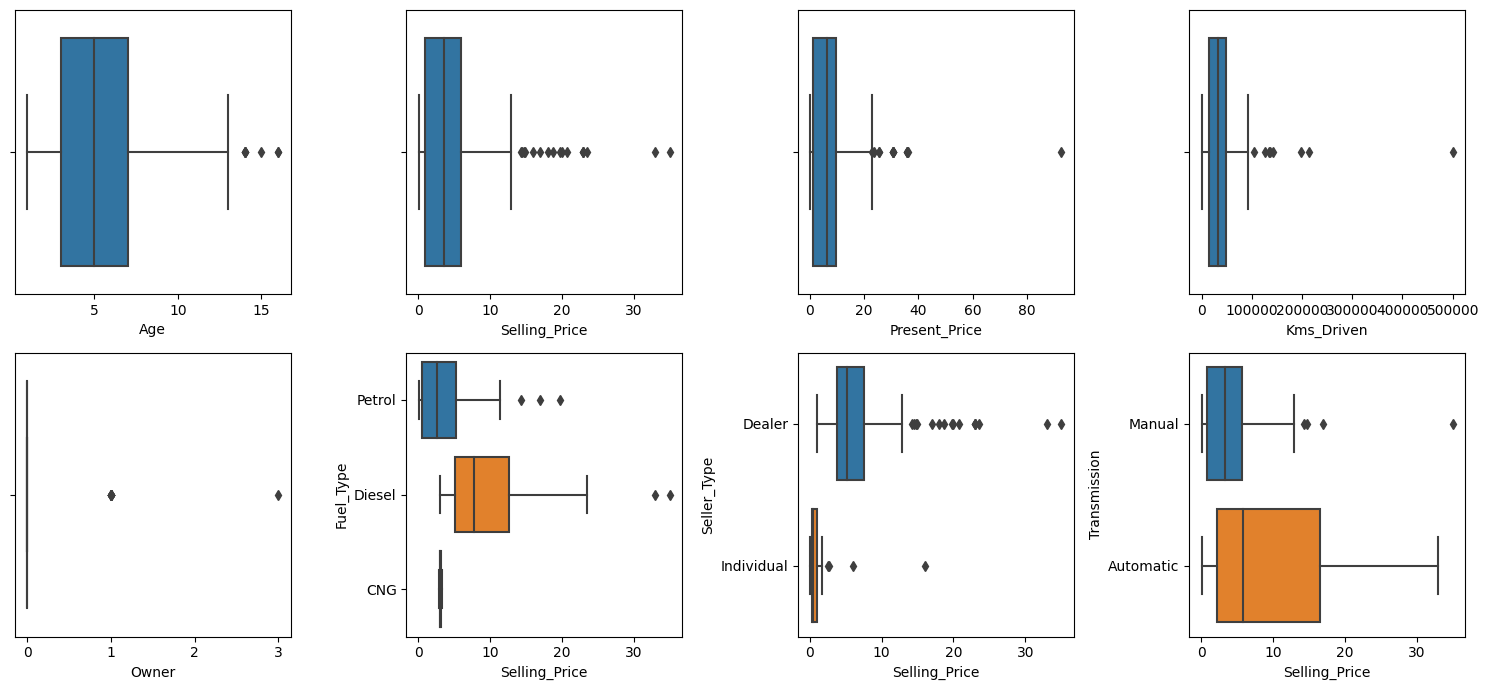

In [5]:
OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values,  df.select_dtypes(include='object').columns.values])
#теперь первые 5 столбцов содержат числовые значения, последние 3 - строки(объекты)
fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i // 4
    y = i % 4
    if i < 5:
        sns.boxplot(data=df, x=col, ax=ax[x,y])
    else:
        sns.boxplot(data=df, y=col, x='Selling_Price', ax=ax[x,y])

plt.tight_layout()    
plt.show()

In [6]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat_name in df[col].unique():
        df1 = df[df[col] == cat_name]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('amount of ourliers:', len(outliers_indexes))
print('indexes of outliers:', outliers_indexes)

amount of ourliers: 38
indexes of outliers: [27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


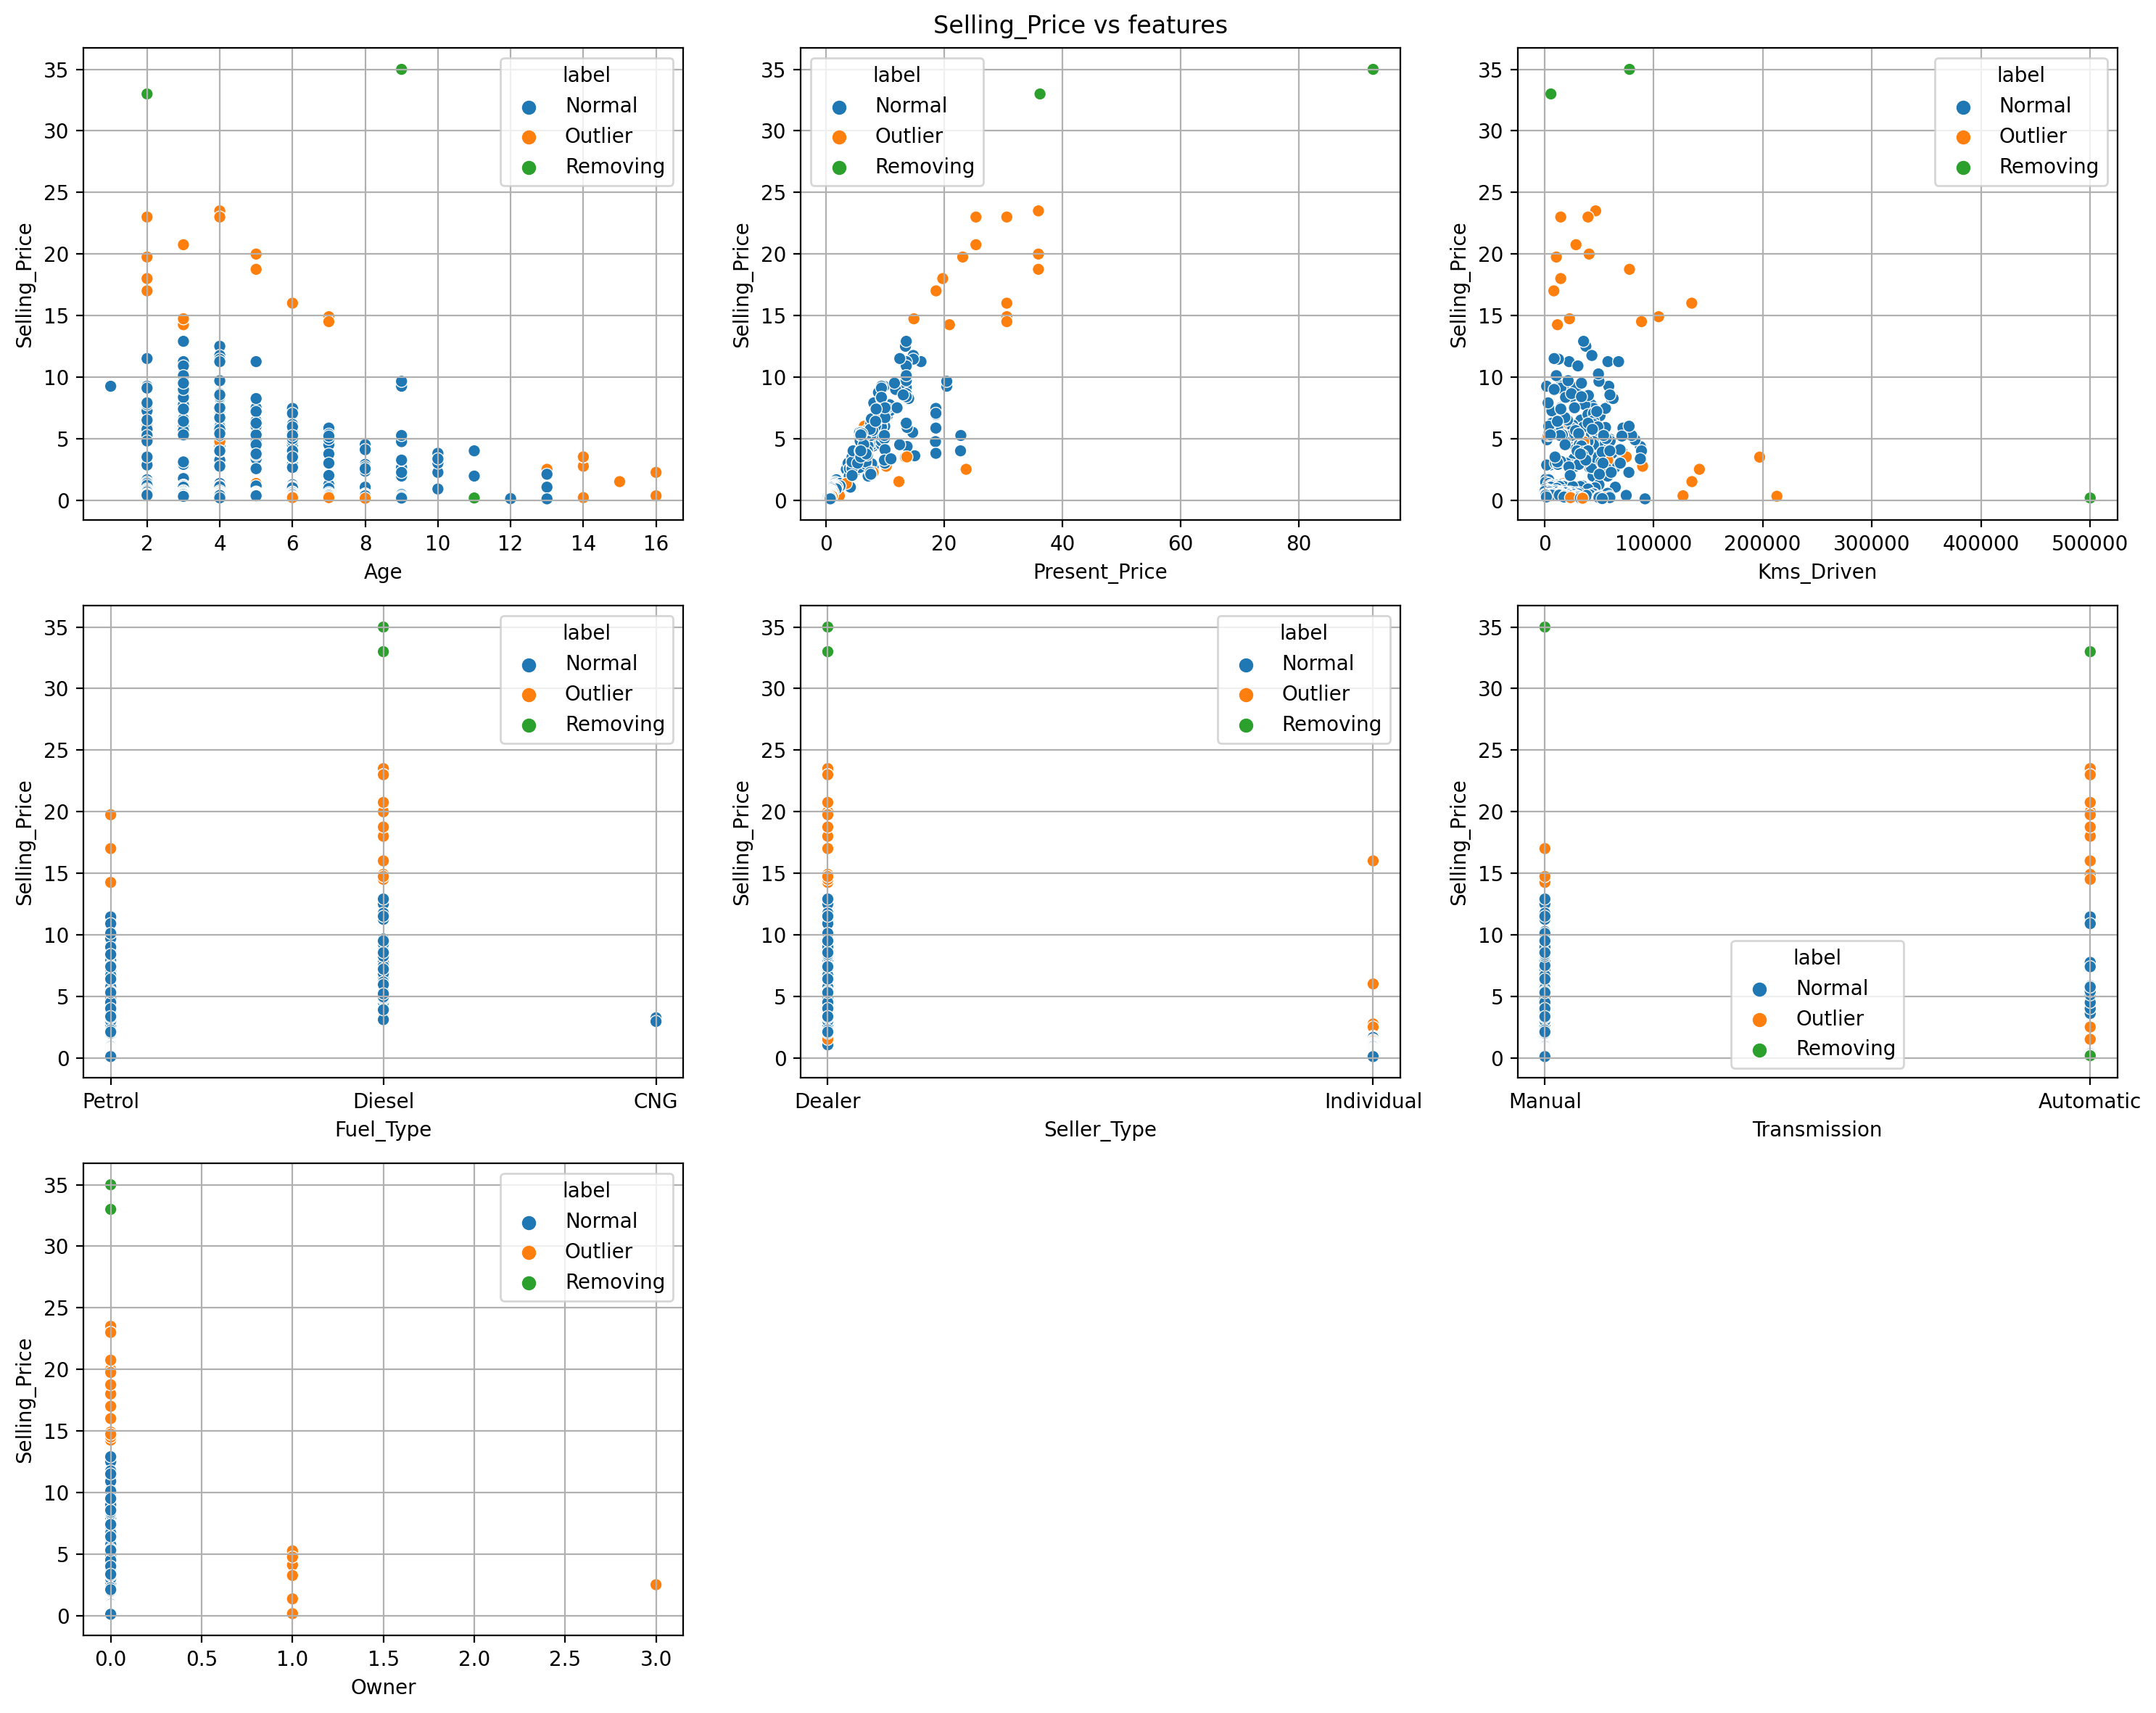

In [7]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1['Selling_Price']>30].index)
removing_indexes.extend(df1[df1['Kms_Driven']>300000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i // 3
    y=i % 3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.suptitle('Selling_Price vs features')
plt.tight_layout()
plt.show()

In [8]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[64, 196, 86]

In [9]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)
df1[25:30]

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
25,8,3.00,4.99,20000,Petrol,Dealer,Manual,0
26,6,4.15,5.87,55138,Petrol,Dealer,Manual,0
27,2,6.00,6.49,16200,Petrol,Individual,Manual,0
28,9,1.95,3.95,44542,Petrol,Dealer,Manual,0
29,4,7.45,10.38,45000,Diesel,Dealer,Manual,0


In [10]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1[25:30]

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
25,8,3.00,4.99,20000,0,False,True,False,True
26,6,4.15,5.87,55138,0,False,True,False,True
27,2,6.00,6.49,16200,0,False,True,True,True
28,9,1.95,3.95,44542,0,False,True,False,True
29,4,7.45,10.38,45000,0,True,False,False,True


# Создание модели

In [11]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Нормализация/стандартизация входных данных (X): свдвиг и масштабирование -> mean=0, dev=1 : z=(x-m)/d 

In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Тренировка модели**


In [13]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,4.387479
Present_Price Coef.,3.525215
Fuel_Type_Diesel Coef.,0.855057
Fuel_Type_Petrol Coef.,0.205256
Transmission_Manual Coef.,-0.159530
Owner Coef.,-0.246675
Seller_Type_Individual Coef.,-0.388958
Kms_Driven Coef.,-0.658306
Age Coef.,-0.880118


# Оценка модели

In [14]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')

,Linear Reg.
MAE,0.958244
MSE,1.547483
RMSE,1.243979
R2-Score,0.931814


# Результат

In [15]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test, 'Predicted':y_test_pred})

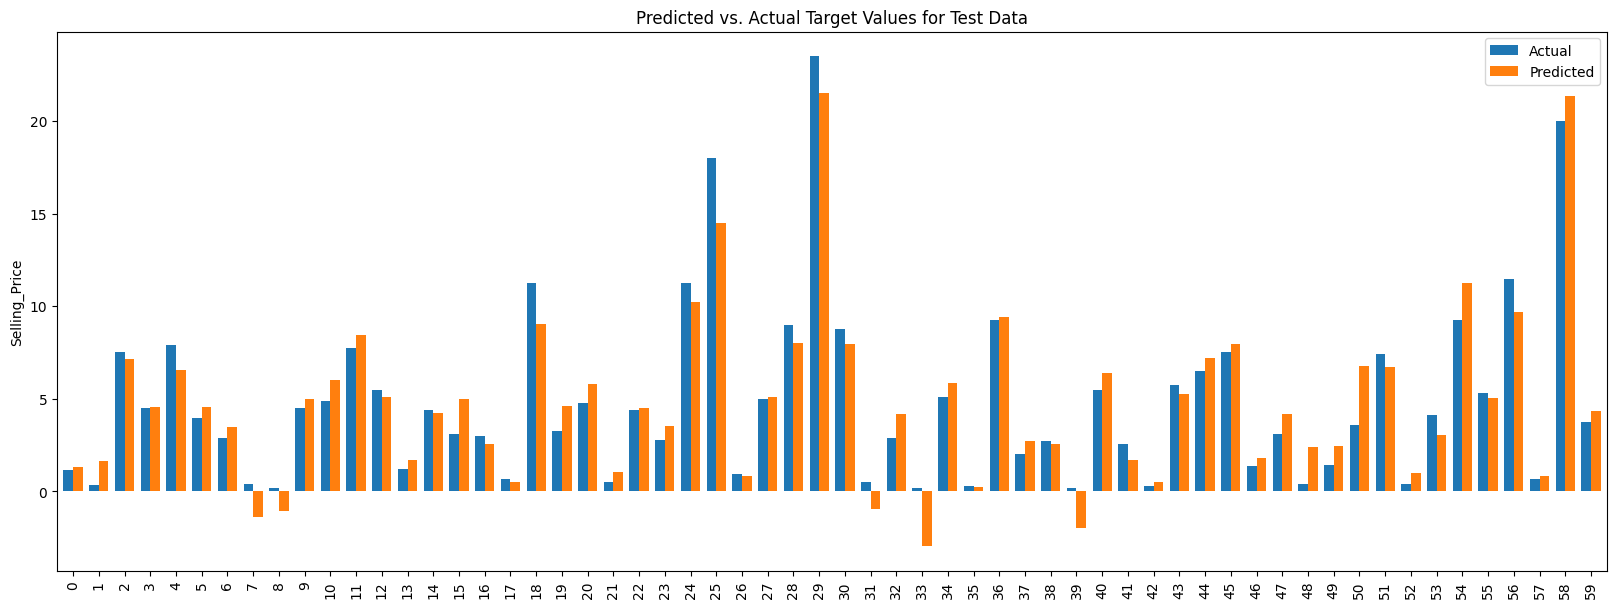

In [16]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.75)
    plt.title('Predicted vs. Actual Target Values for Test Data')
    plt.ylabel('Selling_Price')
    plt.show()

compare_plot(df_comp)

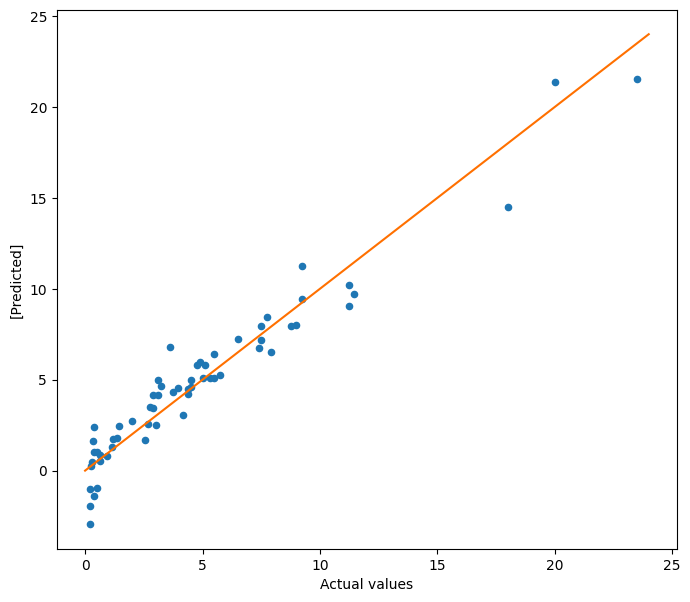

In [17]:
def compare_plot2(df_comp):
    df_comp.plot(x = ['Actual'], y=['Predicted'], kind='scatter', figsize=(8,7))
    x = np.arange(0, 25)
    plt.plot(x, x, color='#ff7000')
    plt.xlabel('Actual values')
    plt.show()
    
compare_plot2(df_comp)